# Analysis of Benchmarking results in R

In [1]:
# no renv for this script, just ensure these are installed from CRAN. Versioning isn't too important
suppressPackageStartupMessages({
    library(ggplot2)
    library(dplyr)
    library(data.table)
    library(bench)
    library(cowplot)
})

In [2]:
# load and rowbind all benchmarking data
files <- list.files("results", pattern = "\\.csv$", full.names = TRUE)
all_data <- lapply(files, function(file) {
    fread(file, data.table = FALSE) %>%
        mutate(tool = tools::file_path_sans_ext(basename(file)))
}) %>%
    bind_rows() %>%
    relocate(tool) %>%
    mutate(tool = as.factor(tool), mem_alloc = as_bench_bytes(mem_alloc)) %>%
    mutate(across(where(is.character), bench::as_bench_time))

print(levels(all_data$tool))
print(dim(all_data))

[1] "dandelion"     "dandelion_mem" "immunarch"     "scirpy"       
[5] "scRepertoire1" "scRepertoire2"
[1] 47 23


Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_line()`).”


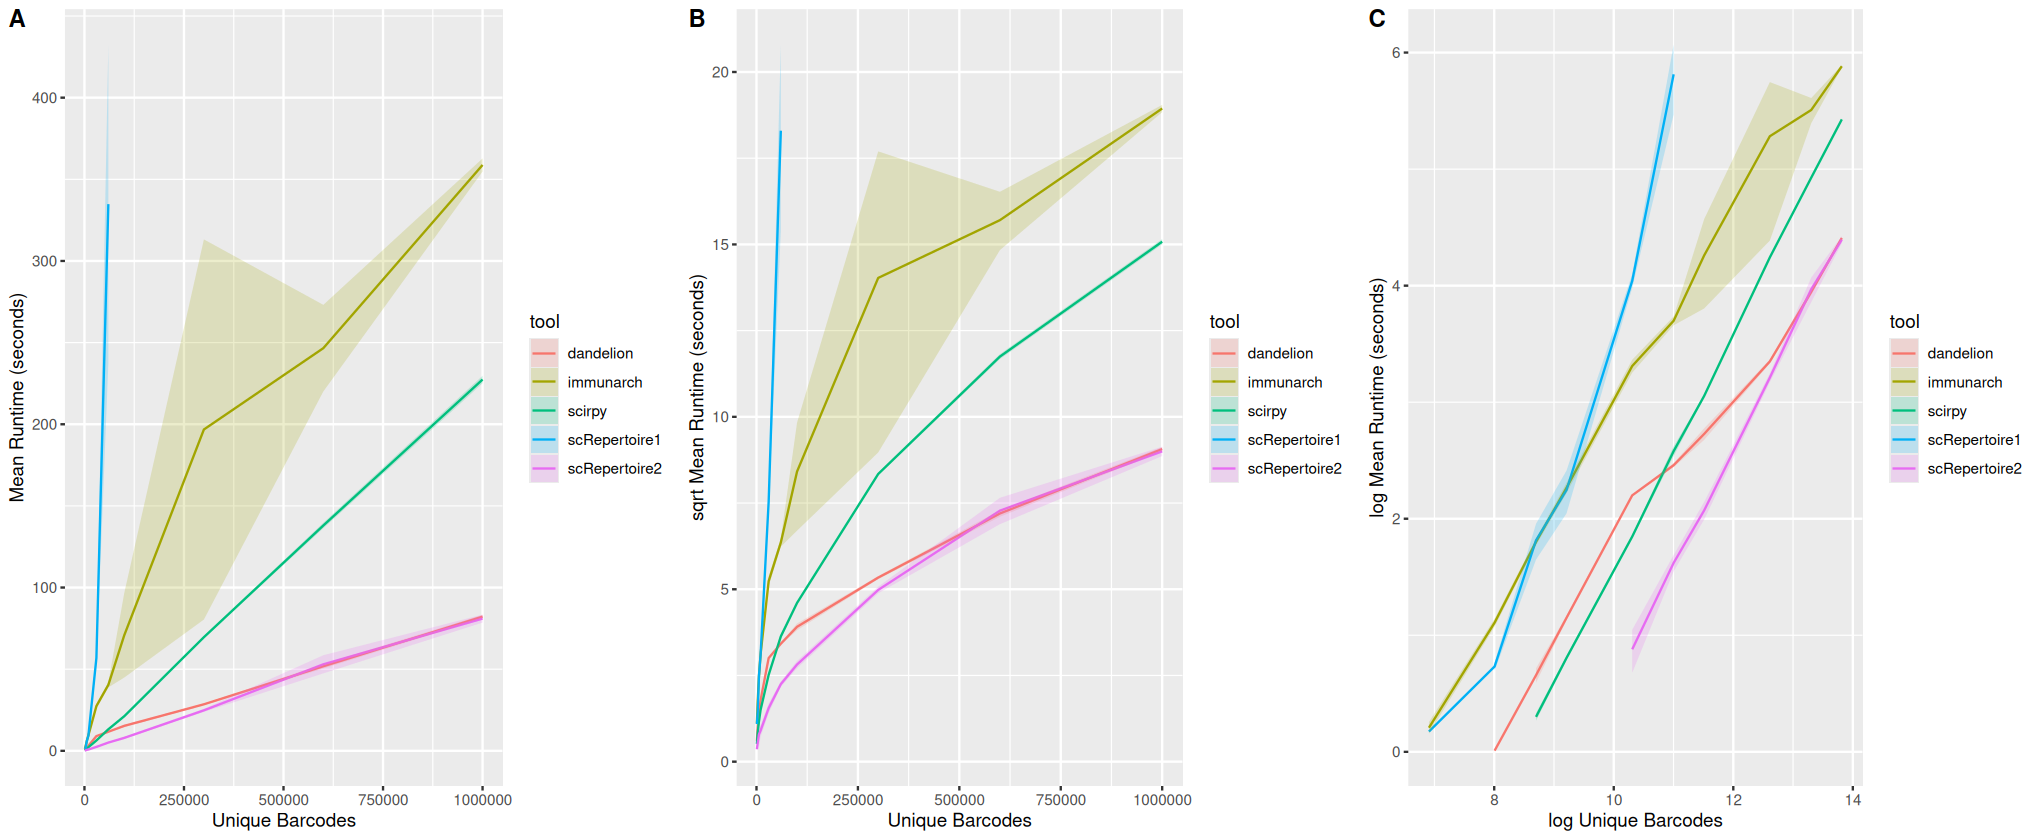

In [7]:
plot_perf <- function(x_trans = identity, y_trans = identity) {

  xlab_prefix <- deparse(substitute(x_trans))
  xlab_prefix <- if (xlab_prefix == "identity") "" else paste0(xlab_prefix, " ") 
  ylab_prefix <- deparse(substitute(y_trans))
  ylab_prefix <- if (ylab_prefix == "identity") "" else paste0(ylab_prefix, " ") 

  ggplot(all_data, aes(x = x_trans(dataset_size), y = y_trans(mean), color = tool, fill = tool)) +
    geom_line() +
    geom_ribbon(aes(ymin = y_trans(mean - ci95), ymax = y_trans(mean + ci95)), alpha = 0.2, color = NA) +
    labs(x = paste0(xlab_prefix, "Unique Barcodes"), y = paste0(ylab_prefix, "Mean Runtime (seconds)")) +
    scale_y_continuous(trans = "identity")
}

options(repr.plot.width = 17, repr.plot.height = 7)
cowplot::plot_grid(plot_perf(), plot_perf(y_trans = sqrt), plot_perf(log, log), ncol = 3, labels="AUTO")

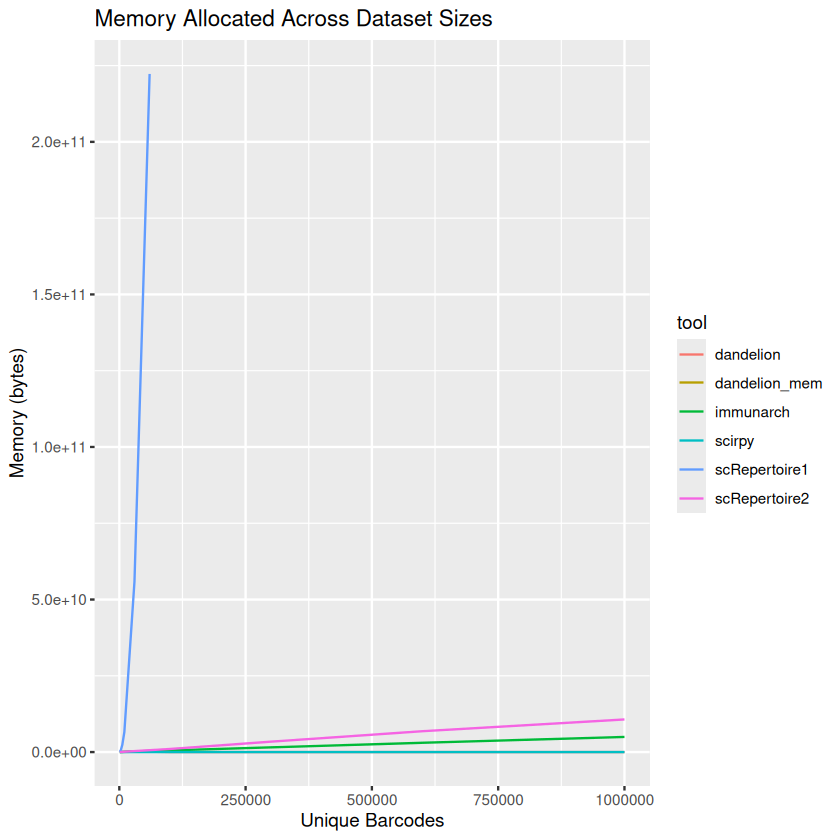

In [3]:
ggplot(all_data, aes(x = dataset_size, y = mem_alloc, color = tool, fill = tool)) +
  geom_line() +
  labs(x = "Unique Barcodes", y = "Memory (bytes)", title = "Memory Allocated Across Dataset Sizes") +
  scale_y_continuous(trans = "identity")

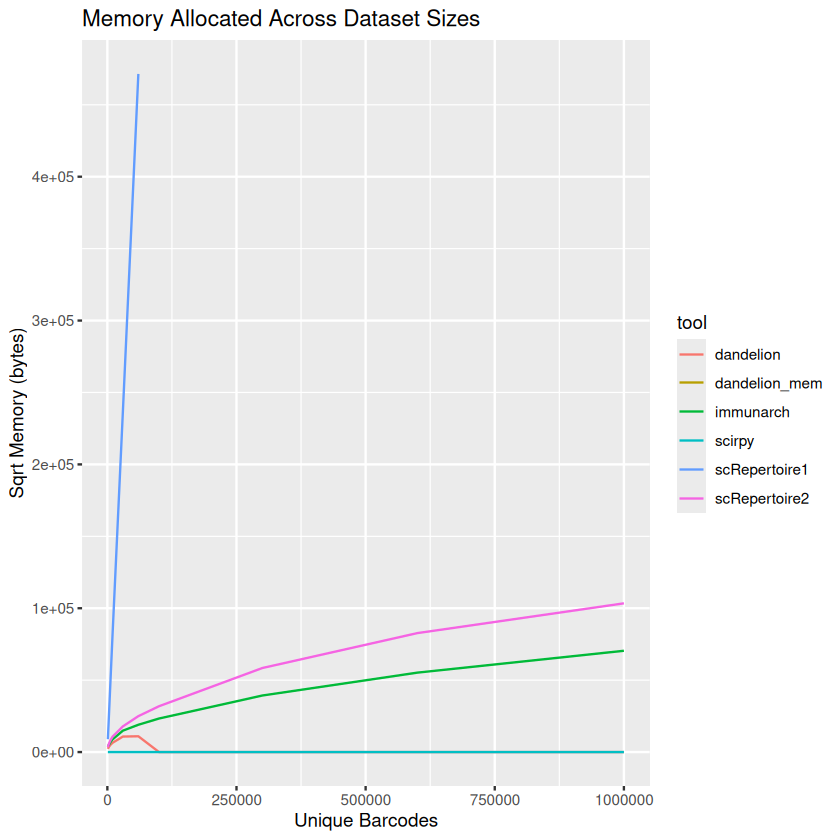

In [4]:
ggplot(all_data, aes(x = dataset_size, y = sqrt(mem_alloc), color = tool, fill = tool)) +
  geom_line() +
  labs(x = "Unique Barcodes", y = "Sqrt Memory (bytes)", title = "Memory Allocated Across Dataset Sizes") +
  scale_y_continuous(trans = "identity")